## Directory

In [1]:
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
os.chdir("/content/drive/MyDrive/vapaad gifs")

## Library

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

## Acquire Data

In [5]:
%%time

# Download and load the dataset.
fpath = keras.utils.get_file(
    "moving_mnist.npy",
    "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy",
)
dataset = np.load(fpath)

# Swap the axes representing the number of frames and number of data samples.
dataset = np.swapaxes(dataset, 0, 1)
# We'll pick out 1000 of the 10000 total examples and use those.
dataset = dataset[:1000, ...]
# Add a channel dimension since the images are grayscale.
dataset = np.expand_dims(dataset, axis=-1)

# Split into train and validation sets using indexing to optimize memory.
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

# Normalize the data to the 0-1 range.
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255


# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y


# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (900, 19, 64, 64, 1), (900, 19, 64, 64, 1)
Validation Dataset Shapes: (100, 19, 64, 64, 1), (100, 19, 64, 64, 1)
CPU times: user 104 ms, sys: 443 ms, total: 548 ms
Wall time: 544 ms


### Visualization

Displaying frames for example 825.


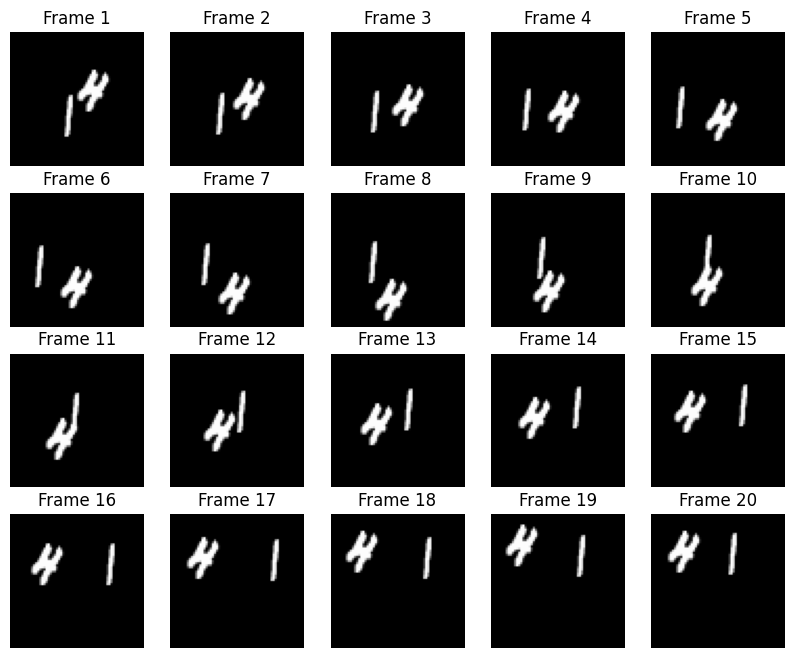

CPU times: user 1.23 s, sys: 251 ms, total: 1.48 s
Wall time: 1.25 s


In [ ]:
%%time

# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

In [ ]:
import matplotlib.pyplot as plt

def plot_image_sequences(x_train, y_train, num_samples=5):
    """
    Plots sequences of input and output images for a number of samples, with titles.

    Args:
    x_train (np.ndarray): Input image sequences.
    y_train (np.ndarray): Output image sequences.
    num_samples (int): Number of samples to plot.
    """
    fig, axes = plt.subplots(num_samples, 38, figsize=(38, num_samples * 2))  # Adjusted figsize for title space
    fig.suptitle("Sample Input/Output Sequence Images from Moving MNIST", fontsize=25, y=1.05)
    plt.figtext(0.5, 1.01, "First 19 frames are input sequences whereas latter 19 frames are output sequences",
                ha='center', fontsize=25, va='top')

    for i in range(num_samples):
        for j in range(19):  # Plot input images
            axes[i, j].imshow(x_train[i, j, :, :, 0], cmap='gray')
            axes[i, j].set_title(f'Frame {j + 1}', fontsize=8)
            axes[i, j].axis('off')
        for j in range(19):  # Plot output images
            axes[i, j + 19].imshow(y_train[i, j, :, :, 0], cmap='gray')
            axes[i, j + 19].set_title(f'Frame {j + 20}', fontsize=8)
            axes[i, j + 19].axis('off')

    plt.tight_layout()
    plt.show()

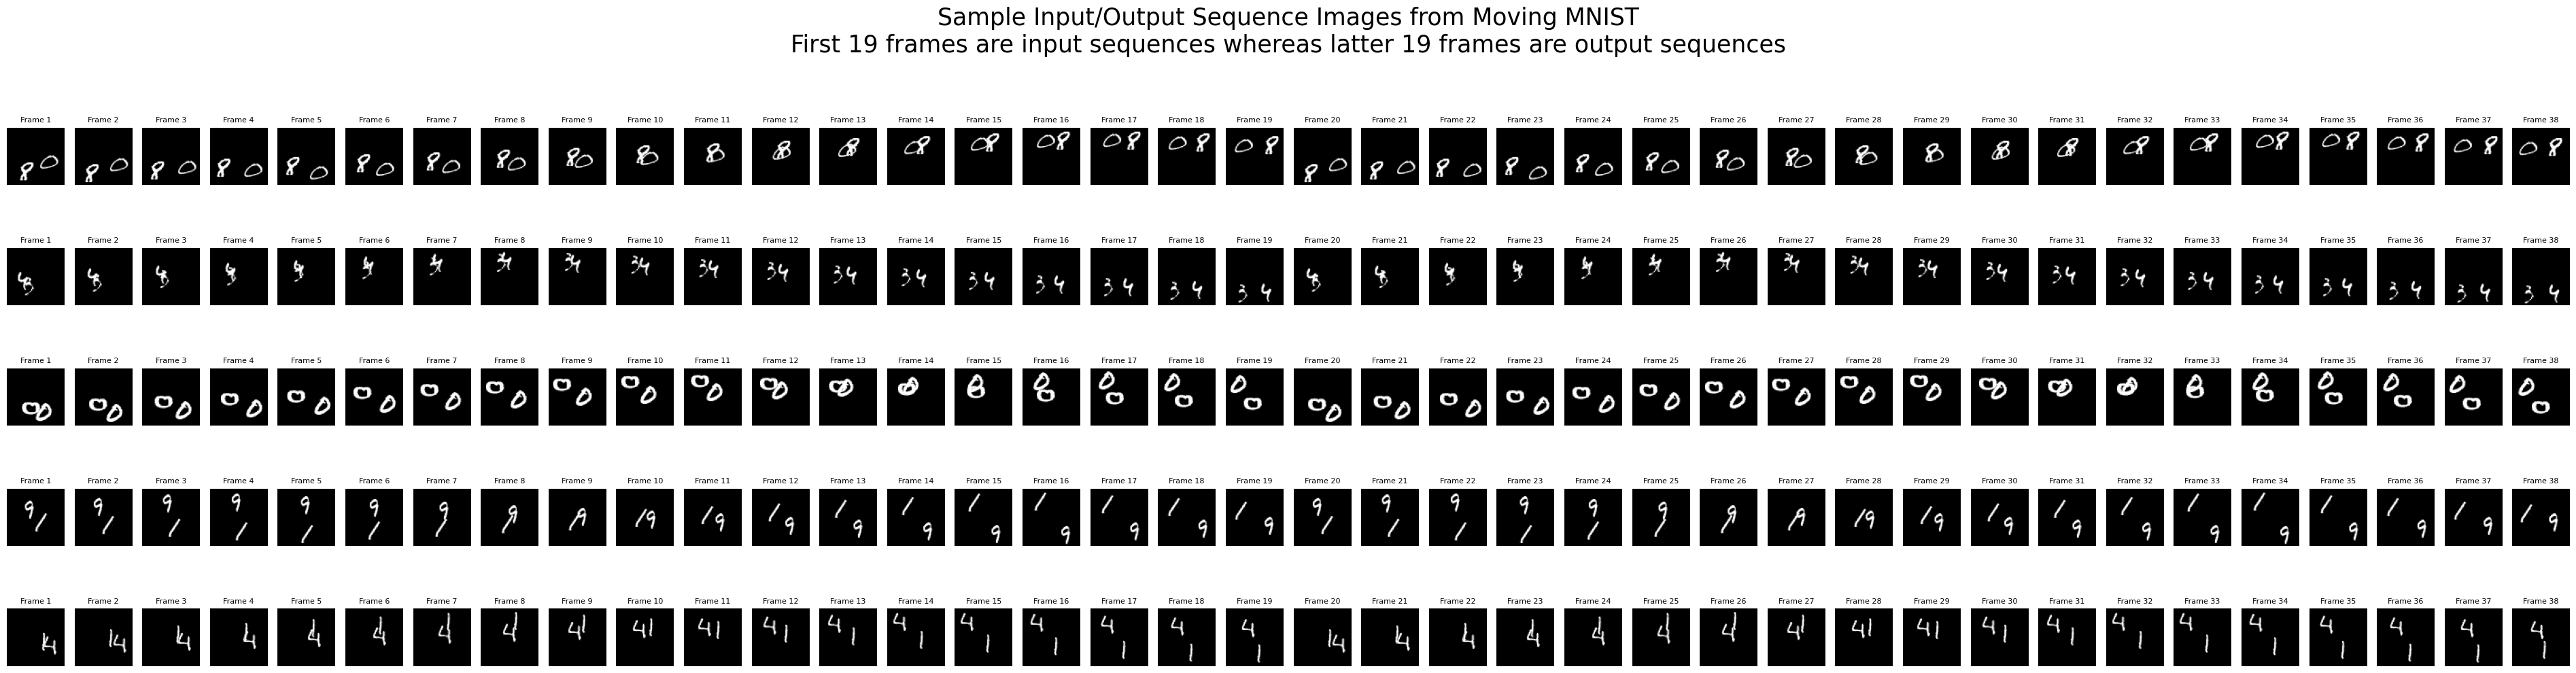

CPU times: user 12.2 s, sys: 403 ms, total: 12.6 s
Wall time: 12.2 s


In [ ]:
%%time

# Example usage
plot_image_sequences(x_train, y_train)

## Build `VAPAAD` Model

In [6]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from typing import Tuple

class SelfAttention(layers.Layer):
    """
    A custom self-attention layer that computes attention scores to enhance model performance by focusing on relevant parts of the input data.

    This layer creates query, key, and value representations of the input, then calculates attention scores to determine how much focus to put on each part of the input data. The output is a combination of the input and the attention mechanism's weighted focus, which allows the model to pay more attention to certain parts of the data.

    Attributes:
        query_dense (keras.layers.Dense): A dense layer for transforming the input into a query tensor.
        key_dense (keras.layers.Dense): A dense layer for transforming the input into a key tensor.
        value_dense (keras.layers.Dense): A dense layer for transforming the input into a value tensor.
        combine_heads (keras.layers.Dense): A dense layer for combining the attention heads' outputs.
    """

    def __init__(self, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)

    def build(self, input_shape: Tuple[int, ...]):
        """
        Initializes the internal dense layers based on the last dimension of the input shape, setting up the query, key, value, and combine heads layers.

        Args:
            input_shape (Tuple[int, ...]): The shape of the input tensor to the layer.
        """
        self.query_dense = layers.Dense(units=input_shape[-1])
        self.key_dense = layers.Dense(units=input_shape[-1])
        self.value_dense = layers.Dense(units=input_shape[-1])
        self.combine_heads = layers.Dense(units=input_shape[-1])

    def call(self, inputs: tf.Tensor) -> tf.Tensor:
        """
        Performs the self-attention mechanism on the input tensor and returns the combined output with a residual connection.

        Args:
            inputs (tf.Tensor): The input tensor to the self-attention layer.

        Returns:
            tf.Tensor: The output tensor after applying self-attention and combining with the input tensor through a residual connection.
        """
        # Generate query, key, value tensors
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        # Calculate attention scores
        scores = tf.matmul(query, key, transpose_b=True)
        distribution = tf.nn.softmax(scores)
        attention_output = tf.matmul(distribution, value)

        # Combine heads and add residual connection
        combined_output = self.combine_heads(attention_output) + inputs
        return combined_output

### Define `VAPAAD`

In [7]:
from typing import Tuple
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

def vapaad(input_shape: Tuple[int, int, int], image_size: int = 64) -> keras.Model:
    """
    Builds a video processing model with data augmentation and self-attention mechanisms.

    Args:
        input_shape (Tuple[int, int, int]): The shape of the input frames.
        image_size (int, optional): The target size to resize the frames. Defaults to 64.

    Returns:
        keras.Model: A compiled keras model ready for training.
    """
    # Initialize the data augmentation pipeline
    data_augmentation = keras.Sequential([
        # layers.RandomFlip("horizontal"),  # Randomly flip frames horizontally
        # layers.RandomRotation(factor=0.02),  # Randomly rotate frames by a small angle
        # layers.RandomRotation(factor=0.2),  # Randomly rotate frames by a small angle
        # layers.RandomRotation(factor=0.3),  # Randomly rotate frames by a small angle
        layers.RandomZoom(height_factor=0.01, width_factor=0.01),  # Randomly zoom in on frames
    ], name="data_augmentation")

    inp = layers.Input(shape=input_shape)  # Define the input layer with the specified shape

    # Apply data augmentation to each frame using the TimeDistributed layer
    x = layers.TimeDistributed(data_augmentation)(inp)

    # First ConvLSTM2D layer with self-attention
    x = layers.ConvLSTM2D(filters=64, kernel_size=(5, 5), padding="same", return_sequences=True, activation="relu")(x)
    x = layers.BatchNormalization()(x)  # Normalize the activations of the first layer
    x = SelfAttention()(x)  # Apply self-attention mechanism

    # Second ConvLSTM2D layer with self-attention
    x = layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), padding="same", return_sequences=True, activation="relu")(x)
    x = layers.BatchNormalization()(x)  # Normalize the activations of the second layer
    x = SelfAttention()(x)  # Apply self-attention mechanism

    # Third ConvLSTM2D layer with self-attention
    x = layers.ConvLSTM2D(filters=64, kernel_size=(1, 1), padding="same", return_sequences=True, activation="relu")(x)
    x = SelfAttention()(x)  # Apply self-attention mechanism

    # Final Conv3D layer to produce the output
    x = layers.Conv3D(filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same")(x)

    # Create the model
    model = keras.models.Model(inputs=inp, outputs=x)

    # Return
    return model

### Define Generators

In [8]:
# Example usage:
# Assuming x_train.shape is (900, 19, 64, 64, 1), indicating (samples, frames, height, width, channels)
gen_past = vapaad(input_shape=(None, *x_train.shape[2:]))
gen_future = vapaad(input_shape=(None, *x_train.shape[2:]))

## Instructor

In [9]:
# Instructor model
def instructor_model(input_shape: Tuple[int, int, int], image_size: int = 64) -> keras.Model:
    """
    Builds a video processing model ending with fully connected layers.

    Args:
        input_shape (Tuple[int, int, int]): The shape of the input frames.
        image_size (int, optional): The target size to resize the frames. Defaults to 64.

    Returns:
        keras.Model: A compiled keras model ready for training with a one-dimensional output.
    """
    # Initialize the data augmentation pipeline
    data_augmentation = keras.Sequential([
        # layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.01, width_factor=0.01),  # Randomly zoom in on frames
    ], name="data_augmentation")

    inp = layers.Input(shape=input_shape)

    # Apply data augmentation to each frame using the TimeDistributed layer
    x = layers.TimeDistributed(data_augmentation)(inp)

    # ConvLSTM2D layers with self-attention
    x = layers.ConvLSTM2D(filters=64, kernel_size=(5, 5), padding="same", return_sequences=True, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = SelfAttention()(x)

    x = layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), padding="same", return_sequences=True, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = SelfAttention()(x)

    x = layers.ConvLSTM2D(filters=64, kernel_size=(1, 1), padding="same", return_sequences=True, activation="relu")(x)
    x = SelfAttention()(x)

    # Adding global average pooling to reduce the dimensionality before dense layers
    x = layers.GlobalAveragePooling3D()(x)

    # Fully connected dense layers
    x = layers.Dense(2048, activation='relu')(x)
    x = layers.Dense(1024, activation='relu')(x)

    # Final dense layer for one-dimensional output
    output = layers.Dense(1, activation='sigmoid')(x)

    # Create the model
    model = keras.models.Model(inputs=inp, outputs=output)

    return model

### Define Instructor

In [10]:
# Example usage:
# Assuming x_train.shape is (900, 19, 64, 64, 1), indicating (samples, frames, height, width, channels)
instructor = instructor_model(input_shape=(None, *x_train.shape[2:]))

In [11]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [12]:
import tensorflow as tf

def generator_loss(fake_output: tf.Tensor) -> tf.Tensor:
    """
    Calculates the loss for the generator model based on its output for generated (fake) images.

    The loss encourages the generator to produce images that the instructor model classifies as real.
    This is achieved by comparing the generator's output for fake images against a target tensor of ones,
    indicating that the ideal output of the generator would be classified as real by the instructor model.

    Args:
    fake_output (tf.Tensor): The generator model's output logits for generated (fake) images.

    Returns:
    tf.Tensor: The loss for the generator model, encouraging it to generate more realistic images.
    """
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [13]:
import tensorflow as tf

def instructor_loss(real_output: tf.Tensor, fake_output: tf.Tensor) -> tf.Tensor:
    """
    Calculates the loss for the instructor model based on its output for real and generated (fake) images.

    The loss is computed as the sum of the cross-entropy losses for the real and fake outputs. For real images,
    the target is a tensor of ones, and for fake images, the target is a tensor of zeros.

    Args:
    real_output (tf.Tensor): The instructor model's output logits for real images.
    fake_output (tf.Tensor): The instructor model's output logits for generated (fake) images.

    Returns:
    tf.Tensor: The total loss for the instructor model, combining the real and fake loss components.
    """
    # Cross-entropy loss for real images (targets are ones)
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    # Cross-entropy loss for fake images (targets are zeros)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    # Sum of real and fake losses
    total_loss = real_loss + fake_loss
    return total_loss

### Learning Rate (with and without customization)

In [14]:
# define two separate optimizer for the generator and the instructor
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
instructor_optimizer = tf.keras.optimizers.Adam(1e-4)

In [15]:
# import tensorflow as tf

# initial_learning_rate = 0.001
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=1000,
#     decay_rate=0.9,
#     staircase=True
# )

# # define two separate optimizer for the generator and the instructor
# # with learning rate scheduler
# generator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
# instructor_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

### Define `train_step`

In [16]:
import numpy as np
import tensorflow as tf
import time
from tqdm import tqdm

@tf.function
def train_step(images: tf.Tensor, future_images: tf.Tensor,
               gen_optimizer: tf.keras.optimizers.Optimizer,
               inst_optimizer: tf.keras.optimizers.Optimizer) -> Tuple[tf.Tensor, tf.Tensor]:
    """
    Perform a single training step by updating the generator and instructor models.

    Args:
        images (tf.Tensor): Input images for the generator model `gen_past`.
        future_images (tf.Tensor): Future images for the generator model `gen_future`.
        gen_optimizer (tf.keras.optimizers.Optimizer): Optimizer for the generator model.
        inst_optimizer (tf.keras.optimizers.Optimizer): Optimizer for the instructor model.

    Returns:
        Tuple[tf.Tensor, tf.Tensor]: Tuple containing the generator loss and instructor loss.
    """

    # Use GradientTape to track operations for automatic differentiation.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as inst_tape:
        # Generate outputs from both current and future input images.
        output_main = gen_past(images, training=True)  # Output from gen_past
        output_aux = gen_future(future_images, training=True)  # Output from gen_future

        # Obtain instructor model outputs for both real and generated images.
        real_output = instructor(output_aux, training=True)  # Instructor output for real images
        fake_output = instructor(output_main, training=True)  # Instructor output for generated images

        # Calculate losses for both generator and instructor models.
        gen_loss = generator_loss(fake_output)  # Loss for generator
        inst_loss = instructor_loss(real_output, fake_output)  # Loss for instructor

    # Compute gradients for generator and instructor.
    gradients_of_gen_past = gen_tape.gradient(gen_loss, gen_past.trainable_variables)  # Gradients for gen_past
    gradients_of_instructor = inst_tape.gradient(inst_loss, instructor.trainable_variables)  # Gradients for instructor

    # Apply gradients to the optimizer for updating model weights.
    gen_optimizer.apply_gradients(zip(gradients_of_gen_past, gen_past.trainable_variables))  # Update gen_past weights
    inst_optimizer.apply_gradients(zip(gradients_of_instructor, instructor.trainable_variables))  # Update instructor weights

    # Update the weights of gen_future using a moving average of gen_past weights.
    alpha = 0.001  # Learning rate for the moving average
    for a, b in zip(gen_future.trainable_variables, gen_past.trainable_variables):
        a.assign(alpha * a + (1 - alpha) * b)  # Update gen_future weights

    # Print current loss values for generator and instructor.
    tf.print("Generator Loss:", gen_loss, "; Instructor Loss:", inst_loss)

    # Return the losses for logging or any other purposes.
    return gen_loss, inst_loss

In [17]:
import numpy as np
import tensorflow as tf
import time
from tqdm import tqdm
from typing import Tuple

def train(x_train: np.ndarray, y_train: np.ndarray, epochs: int, batch_size: int = 64) -> None:
    """
    Trains the model for a given number of epochs with specified batch size.

    This function iterates over the entire dataset for a specified number of epochs,
    randomly selecting batches of data to perform training steps. The selection is random
    and without replacement within each epoch, ensuring diverse exposure of data.

    Args:
    x_train (np.ndarray): The input training data.
    y_train (np.ndarray): The target training data.
    epochs (int): The number of times to iterate over the entire dataset.
    batch_size (int, optional): The number of samples per batch of computation. Defaults to 64.

    Returns:
    None
    """
    # Determine the number of samples in the training dataset.
    n_samples = x_train.shape[0]

    # Iterate over the dataset for the specified number of epochs.
    for epoch in range(epochs):
        start = time.time()  # Record the start time of the epoch.
        indices = np.arange(n_samples)  # Create an array of indices corresponding to the dataset.
        np.random.shuffle(indices)  # Shuffle the indices to ensure random batch selection.

        # Iterate over the dataset in batches.
        for i in tqdm(range(0, n_samples, batch_size)):
            selected_indices = np.random.choice(indices, size=batch_size, replace=False)  # Randomly select indices for the batch.
            x_batch = x_train[selected_indices]  # Extract the batch of input data.
            y_batch = y_train[selected_indices]  # Extract the batch of target data.
            # curr_gen_loss, curr_inst_loss = train_step(x_batch, y_batch)  # Perform a training step with the selected batch.
            curr_gen_loss, curr_inst_loss = train_step(x_batch, y_batch, generator_optimizer, instructor_optimizer) # Perform a training step with the selected batch.

            if curr_gen_loss < 0.2:
                break

        # Print the time taken to complete the epoch.
        print(f'Time for epoch {epoch + 1} is {time.time() - start} sec')

In [18]:
# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (900, 19, 64, 64, 1), (900, 19, 64, 64, 1)
Validation Dataset Shapes: (100, 19, 64, 64, 1), (100, 19, 64, 64, 1)


In [19]:
# Check gpu
tf.test.gpu_device_name()

'/device:GPU:0'

In [20]:
# Convert the data to a smaller data type to reduce memory usage
x_train = x_train.astype(np.float16)
y_train = y_train.astype(np.float16)

In [21]:
# Assuming x_train and y_train are already defined and loaded
num_samples = 64
indices = np.random.choice(x_train.shape[0], num_samples, replace=False)
print(indices[0:6])
x_train_sub = x_train[indices]
y_train_sub = y_train[indices]
print(x_train_sub.shape, y_train_sub.shape)

[311  33 714 169  54 366]
(64, 19, 64, 64, 1) (64, 19, 64, 64, 1)


### Training

In [ ]:
%%time

# Assuming x_train and y_train are already defined and loaded
num_samples = 32
indices = np.random.choice(x_train.shape[0], num_samples, replace=False)
print(indices[0:6])
x_train_sub = x_train[indices]
y_train_sub = y_train[indices]
print(x_train_sub.shape, y_train_sub.shape)

# Example usage:
if tf.test.gpu_device_name() != '':
    with tf.device('/device:GPU:0'):
        train(x_train_sub, y_train_sub, epochs=1, batch_size=1)
else:
    train(x_train_sub, y_train_sub, epochs=1, batch_size=1)

[833 648  11 131  76 704]
(32, 19, 64, 64, 1) (32, 19, 64, 64, 1)


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Generator Loss: 0.65321517 ; Instructor Loss: 1.38404715


  3%|▎         | 1/32 [01:12<37:41, 72.96s/it]

Generator Loss: 0.646032 ; Instructor Loss: 1.38756359


  6%|▋         | 2/32 [01:23<18:00, 36.02s/it]

Generator Loss: 0.710444033 ; Instructor Loss: 1.38368702


  9%|▉         | 3/32 [01:33<11:39, 24.13s/it]

Generator Loss: 0.705363154 ; Instructor Loss: 1.38712645


 12%|█▎        | 4/32 [01:43<08:41, 18.63s/it]

Generator Loss: 0.679628253 ; Instructor Loss: 1.38438642


 16%|█▌        | 5/32 [01:53<06:58, 15.49s/it]

Generator Loss: 0.700626493 ; Instructor Loss: 1.38811457


 19%|█▉        | 6/32 [02:02<05:50, 13.49s/it]

Generator Loss: 0.686327755 ; Instructor Loss: 1.38389349


 22%|██▏       | 7/32 [02:13<05:10, 12.41s/it]

Generator Loss: 0.711135268 ; Instructor Loss: 1.38536596


 25%|██▌       | 8/32 [02:22<04:39, 11.63s/it]

Generator Loss: 0.688248515 ; Instructor Loss: 1.38782787


 28%|██▊       | 9/32 [02:32<04:11, 10.91s/it]

Generator Loss: 0.641400099 ; Instructor Loss: 1.38517404


 31%|███▏      | 10/32 [02:42<03:52, 10.56s/it]

Generator Loss: 0.675744772 ; Instructor Loss: 1.37889886


 34%|███▍      | 11/32 [02:52<03:42, 10.59s/it]

Generator Loss: 0.672848403 ; Instructor Loss: 1.38553715


 38%|███▊      | 12/32 [03:02<03:29, 10.47s/it]

Generator Loss: 0.722554743 ; Instructor Loss: 1.39831281


 41%|████      | 13/32 [03:12<03:14, 10.25s/it]

Generator Loss: 0.782149136 ; Instructor Loss: 1.3992399


 44%|████▍     | 14/32 [03:22<03:01, 10.06s/it]

Generator Loss: 0.747297585 ; Instructor Loss: 1.38975668


 47%|████▋     | 15/32 [03:31<02:47,  9.85s/it]

Generator Loss: 0.74630934 ; Instructor Loss: 1.36878848


 50%|█████     | 16/32 [03:41<02:36,  9.78s/it]

Generator Loss: 0.644776642 ; Instructor Loss: 1.38968205


 53%|█████▎    | 17/32 [03:50<02:25,  9.71s/it]

Generator Loss: 0.612874 ; Instructor Loss: 1.38882053


 56%|█████▋    | 18/32 [03:59<02:13,  9.52s/it]

Generator Loss: 0.568870246 ; Instructor Loss: 1.42041659


 59%|█████▉    | 19/32 [04:09<02:04,  9.55s/it]

Generator Loss: 0.60646069 ; Instructor Loss: 1.41107154


 62%|██████▎   | 20/32 [04:19<01:54,  9.57s/it]

Generator Loss: 0.750718355 ; Instructor Loss: 1.3797518


 66%|██████▌   | 21/32 [04:28<01:44,  9.52s/it]

Generator Loss: 0.787211061 ; Instructor Loss: 1.40942681


 69%|██████▉   | 22/32 [04:38<01:35,  9.51s/it]

Generator Loss: 0.781499863 ; Instructor Loss: 1.39172709


 72%|███████▏  | 23/32 [04:47<01:25,  9.52s/it]

Generator Loss: 0.750560164 ; Instructor Loss: 1.36059988


 75%|███████▌  | 24/32 [04:56<01:15,  9.45s/it]

Generator Loss: 0.688599586 ; Instructor Loss: 1.41744149


 78%|███████▊  | 25/32 [05:06<01:06,  9.49s/it]

Generator Loss: 0.646433532 ; Instructor Loss: 1.37136292


 81%|████████▏ | 26/32 [05:15<00:56,  9.43s/it]

Generator Loss: 0.591721356 ; Instructor Loss: 1.39823294


 84%|████████▍ | 27/32 [05:25<00:47,  9.42s/it]

Generator Loss: 0.669672 ; Instructor Loss: 1.40891886


 88%|████████▊ | 28/32 [05:34<00:37,  9.47s/it]

Generator Loss: 0.670749784 ; Instructor Loss: 1.40219092


 91%|█████████ | 29/32 [05:43<00:28,  9.40s/it]

Generator Loss: 0.709772766 ; Instructor Loss: 1.41366267


 94%|█████████▍| 30/32 [05:53<00:18,  9.48s/it]

Generator Loss: 0.696537375 ; Instructor Loss: 1.42034018


 97%|█████████▋| 31/32 [06:03<00:09,  9.51s/it]

Generator Loss: 0.785571098 ; Instructor Loss: 1.40107775


100%|██████████| 32/32 [06:12<00:00, 11.64s/it]

Time for epoch 1 is 372.4312620162964 sec
CPU times: user 37min 29s, sys: 1min 22s, total: 38min 52s
Wall time: 6min 12s


## Prediction

In [ ]:
%%time

# prediction on validation set
y_val_pred = gen_past.predict(x_val)

print("Shape of true y_val:", y_val.shape)
print("Shape of predicted y_val:", y_val_pred.shape)

4/4 [==============================] - 97s 21s/step
Shape of true y_val: (100, 19, 64, 64, 1)
Shape of predicted y_val: (100, 19, 64, 64, 1)
CPU times: user 8min 29s, sys: 1min 1s, total: 9min 31s
Wall time: 1min 37s


In [22]:
import numpy as np

def rescale_and_discretize(image):
    """
    Rescales an image to the 0-1 range and discretizes the values into levels {0.1, 0.2, ..., 0.9}.

    Args:
    image (np.ndarray): The input image to be rescaled and discretized.

    Returns:
    np.ndarray: The rescaled and discretized image.
    """
    # Rescale image to 0-1 range
    min_val = np.min(image)
    max_val = np.max(image)
    normalized_image = (image - min_val) / (max_val - min_val) if max_val > min_val else image

    # Discretize to nearest levels in {0.1, 0.2, ..., 0.9}
    levels = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
    discretized_image = np.round(normalized_image * 9) / 10  # Multiplies by 9, rounds, then divides by 10
    discretized_image = np.clip(discretized_image, 0.1, 0.9)  # Ensures values are within the specified levels

    return discretized_image

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the figure with specified dimensions
plt.figure(figsize=(20, 6))

# Randomly select 5 samples
num_samples = 2
indices = np.random.choice(y_val.shape[0], num_samples, replace=False)

# Total number of plots per sample (19 predictions + 19 actuals)
num_plots_per_sample = 19 * 2  # 19 predicted and 19 actual

# Iterate over each of the randomly selected samples
for idx, sample_index in enumerate(indices):
    # First row for y_val (true values)
    for i in range(19):
        ax = plt.subplot(num_samples * 2, 19, 2 * idx * 19 + i + 1)  # Calculate position index
        plt.imshow(y_val[sample_index, i, :, :, 0], cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title(f'Sample {sample_index+1} - True Frames')
        plt.text(0.5, -0.1, f't={i+1}', ha='center', va='center', transform=ax.transAxes, fontsize=8)  # Adding time label

    # Second row for y_val_pred (predicted values)
    for i in range(19):
        plt.subplot(num_samples * 2, 19, (2 * idx + 1) * 19 + i + 1)  # Calculate position index
        image = y_val_pred[sample_index, i, :, :, 0]
        result_image = rescale_and_discretize(image)
        plt.imshow(result_image, cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title(f'Sample {sample_index+1} - Pred Frames')

plt.tight_layout()
plt.show()

In [ ]:
# Example usage with an image y_val_pred[sample_index, i, :, :, 0]
# Assuming y_val_pred[sample_index, i, :, :, 0] is your input image:
image = y_val_pred[sample_index, i, :, :, 0]
result_image = rescale_and_discretize(image)
print("Shape:", result_image.shape)
print("Min:", result_image.min())
print("Max:", result_image.max())

Shape: (64, 64)
Min: 0.1
Max: 0.9


### Brute Force

[492 333  47  77 475 555]
(32, 19, 64, 64, 1) (32, 19, 64, 64, 1)


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Generator Loss: 0.712850392 ; Instructor Loss: 1.38875675


  3%|▎         | 1/32 [00:58<30:01, 58.13s/it]

Generator Loss: 0.703259528 ; Instructor Loss: 1.38826108


  6%|▋         | 2/32 [00:59<12:13, 24.47s/it]

Generator Loss: 0.698415935 ; Instructor Loss: 1.37302649


  9%|▉         | 3/32 [00:59<06:36, 13.68s/it]

Generator Loss: 0.669186 ; Instructor Loss: 1.36133969


 12%|█▎        | 4/32 [01:00<04:01,  8.61s/it]

Generator Loss: 0.645496547 ; Instructor Loss: 1.39865363


 16%|█▌        | 5/32 [01:01<02:36,  5.81s/it]

Generator Loss: 0.930117249 ; Instructor Loss: 1.29944324


 19%|█▉        | 6/32 [01:02<01:47,  4.12s/it]

Generator Loss: 0.368685365 ; Instructor Loss: 1.5421859


 22%|██▏       | 7/32 [01:03<01:16,  3.05s/it]

Generator Loss: 0.777038574 ; Instructor Loss: 1.36123872


 25%|██▌       | 8/32 [01:04<00:56,  2.35s/it]

Generator Loss: 0.727514 ; Instructor Loss: 1.42198718


 28%|██▊       | 9/32 [01:04<00:43,  1.88s/it]

Generator Loss: 0.767712533 ; Instructor Loss: 1.37950671


 31%|███▏      | 10/32 [01:05<00:34,  1.57s/it]

Generator Loss: 0.751561344 ; Instructor Loss: 1.40405953


 34%|███▍      | 11/32 [01:06<00:28,  1.35s/it]

Generator Loss: 0.709888 ; Instructor Loss: 1.37631321


 38%|███▊      | 12/32 [01:07<00:23,  1.20s/it]

Generator Loss: 0.750112832 ; Instructor Loss: 1.40433574


 41%|████      | 13/32 [01:08<00:20,  1.09s/it]

Generator Loss: 0.676481366 ; Instructor Loss: 1.3784107


 44%|████▍     | 14/32 [01:09<00:18,  1.02s/it]

Generator Loss: 0.709745347 ; Instructor Loss: 1.38916779


 47%|████▋     | 15/32 [01:10<00:16,  1.03it/s]

Generator Loss: 0.655519128 ; Instructor Loss: 1.41397595


 50%|█████     | 16/32 [01:10<00:14,  1.07it/s]

Generator Loss: 0.694113612 ; Instructor Loss: 1.37655449


 53%|█████▎    | 17/32 [01:11<00:13,  1.10it/s]

Generator Loss: 0.687612295 ; Instructor Loss: 1.38241744


 56%|█████▋    | 18/32 [01:12<00:12,  1.12it/s]

Generator Loss: 0.689199924 ; Instructor Loss: 1.38339198


 59%|█████▉    | 19/32 [01:13<00:11,  1.14it/s]

Generator Loss: 0.649165511 ; Instructor Loss: 1.39852715


 62%|██████▎   | 20/32 [01:14<00:10,  1.14it/s]

Generator Loss: 0.674699545 ; Instructor Loss: 1.37800956


 66%|██████▌   | 21/32 [01:15<00:09,  1.15it/s]

Generator Loss: 0.632654727 ; Instructor Loss: 1.40800846


 69%|██████▉   | 22/32 [01:16<00:08,  1.16it/s]

Generator Loss: 0.678456068 ; Instructor Loss: 1.37233043


 72%|███████▏  | 23/32 [01:16<00:07,  1.16it/s]

Generator Loss: 0.678590536 ; Instructor Loss: 1.38509035


 75%|███████▌  | 24/32 [01:17<00:06,  1.16it/s]

Generator Loss: 0.77791959 ; Instructor Loss: 1.38713658


 78%|███████▊  | 25/32 [01:18<00:06,  1.16it/s]

Generator Loss: 0.911838 ; Instructor Loss: 1.40281391


 81%|████████▏ | 26/32 [01:19<00:05,  1.16it/s]

Generator Loss: 0.670456648 ; Instructor Loss: 1.3771714


 84%|████████▍ | 27/32 [01:20<00:04,  1.16it/s]

Generator Loss: 0.678931892 ; Instructor Loss: 1.3879807


 88%|████████▊ | 28/32 [01:21<00:03,  1.16it/s]

Generator Loss: 0.636698246 ; Instructor Loss: 1.38695765


 91%|█████████ | 29/32 [01:22<00:02,  1.16it/s]

Generator Loss: 0.629643202 ; Instructor Loss: 1.39580917


 94%|█████████▍| 30/32 [01:22<00:01,  1.16it/s]

Generator Loss: 0.652966857 ; Instructor Loss: 1.39527488


 97%|█████████▋| 31/32 [01:23<00:00,  1.16it/s]

Generator Loss: 0.655153751 ; Instructor Loss: 1.38434386


100%|██████████| 32/32 [01:24<00:00,  2.65s/it]


Time for epoch 1 is 84.68753814697266 sec
4/4 [==============================] - 8s 1s/step
Shape of true y_val: (100, 19, 64, 64, 1)
Shape of predicted y_val: (100, 19, 64, 64, 1)


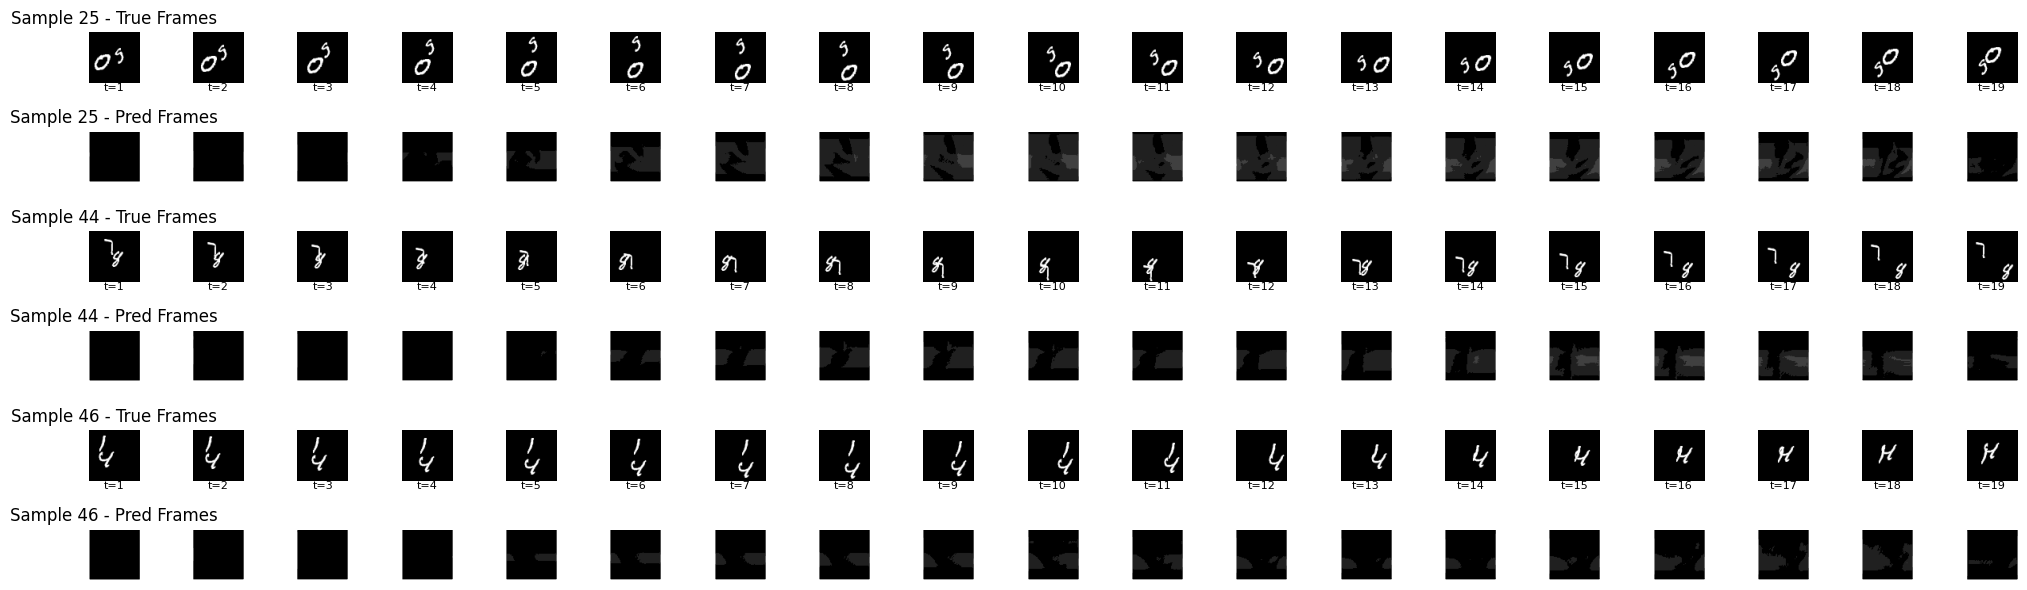

... finished with round: 0 ...
[736  26 869 676  82  51]
(32, 19, 64, 64, 1) (32, 19, 64, 64, 1)


  0%|          | 0/32 [00:00<?, ?it/s]

Generator Loss: 0.710823536 ; Instructor Loss: 1.39483786


  3%|▎         | 1/32 [00:00<00:29,  1.06it/s]

Generator Loss: 0.670370698 ; Instructor Loss: 1.38011932


  6%|▋         | 2/32 [00:01<00:26,  1.11it/s]

Generator Loss: 0.666377306 ; Instructor Loss: 1.39529681


  9%|▉         | 3/32 [00:02<00:25,  1.13it/s]

Generator Loss: 0.698374629 ; Instructor Loss: 1.38436699


 12%|█▎        | 4/32 [00:03<00:24,  1.14it/s]

Generator Loss: 0.735597551 ; Instructor Loss: 1.38821614


 16%|█▌        | 5/32 [00:04<00:23,  1.14it/s]

Generator Loss: 0.731353164 ; Instructor Loss: 1.38023


 19%|█▉        | 6/32 [00:05<00:22,  1.14it/s]

Generator Loss: 0.725295305 ; Instructor Loss: 1.38378048


 22%|██▏       | 7/32 [00:06<00:21,  1.14it/s]

Generator Loss: 0.690174282 ; Instructor Loss: 1.3765471


 25%|██▌       | 8/32 [00:07<00:21,  1.13it/s]

Generator Loss: 0.646149278 ; Instructor Loss: 1.37960362


 28%|██▊       | 9/32 [00:07<00:20,  1.13it/s]

Generator Loss: 0.629096687 ; Instructor Loss: 1.41892314


 31%|███▏      | 10/32 [00:08<00:19,  1.13it/s]

Generator Loss: 0.714574158 ; Instructor Loss: 1.38421702


 34%|███▍      | 11/32 [00:09<00:18,  1.13it/s]

Generator Loss: 0.680671096 ; Instructor Loss: 1.38643157


 38%|███▊      | 12/32 [00:10<00:17,  1.13it/s]

Generator Loss: 0.674989581 ; Instructor Loss: 1.38955283


 41%|████      | 13/32 [00:11<00:16,  1.13it/s]

Generator Loss: 0.705323815 ; Instructor Loss: 1.384395


 44%|████▍     | 14/32 [00:12<00:15,  1.13it/s]

Generator Loss: 0.652767956 ; Instructor Loss: 1.39668727


 47%|████▋     | 15/32 [00:13<00:15,  1.13it/s]

Generator Loss: 0.657013774 ; Instructor Loss: 1.38830566


 50%|█████     | 16/32 [00:14<00:14,  1.13it/s]

Generator Loss: 0.6950683 ; Instructor Loss: 1.38798928


 53%|█████▎    | 17/32 [00:15<00:13,  1.13it/s]

Generator Loss: 0.696931183 ; Instructor Loss: 1.38352132


 56%|█████▋    | 18/32 [00:15<00:12,  1.13it/s]

Generator Loss: 0.697270215 ; Instructor Loss: 1.39355147


 59%|█████▉    | 19/32 [00:16<00:11,  1.13it/s]

Generator Loss: 0.729485273 ; Instructor Loss: 1.37838376


 62%|██████▎   | 20/32 [00:17<00:10,  1.12it/s]

Generator Loss: 0.694431 ; Instructor Loss: 1.38196874


 66%|██████▌   | 21/32 [00:18<00:09,  1.12it/s]

Generator Loss: 0.670784473 ; Instructor Loss: 1.39811087


 69%|██████▉   | 22/32 [00:19<00:08,  1.12it/s]

Generator Loss: 0.721064687 ; Instructor Loss: 1.41626978


 72%|███████▏  | 23/32 [00:20<00:08,  1.12it/s]

Generator Loss: 0.690134645 ; Instructor Loss: 1.39831495


 75%|███████▌  | 24/32 [00:21<00:07,  1.12it/s]

Generator Loss: 0.722053945 ; Instructor Loss: 1.37530804


 78%|███████▊  | 25/32 [00:22<00:06,  1.12it/s]

Generator Loss: 0.705727756 ; Instructor Loss: 1.39521861


 81%|████████▏ | 26/32 [00:23<00:05,  1.12it/s]

Generator Loss: 0.702903032 ; Instructor Loss: 1.39383912


 84%|████████▍ | 27/32 [00:23<00:04,  1.12it/s]

Generator Loss: 0.706556916 ; Instructor Loss: 1.38606298


 88%|████████▊ | 28/32 [00:24<00:03,  1.12it/s]

Generator Loss: 0.678885937 ; Instructor Loss: 1.38160121


 91%|█████████ | 29/32 [00:25<00:02,  1.12it/s]

Generator Loss: 0.671890438 ; Instructor Loss: 1.39361346


 94%|█████████▍| 30/32 [00:26<00:01,  1.12it/s]

Generator Loss: 0.676828682 ; Instructor Loss: 1.37187827


 97%|█████████▋| 31/32 [00:27<00:00,  1.12it/s]

Generator Loss: 0.68574369 ; Instructor Loss: 1.38815475


100%|██████████| 32/32 [00:28<00:00,  1.13it/s]


Time for epoch 1 is 28.438702821731567 sec
4/4 [==============================] - 5s 1s/step
Shape of true y_val: (100, 19, 64, 64, 1)
Shape of predicted y_val: (100, 19, 64, 64, 1)


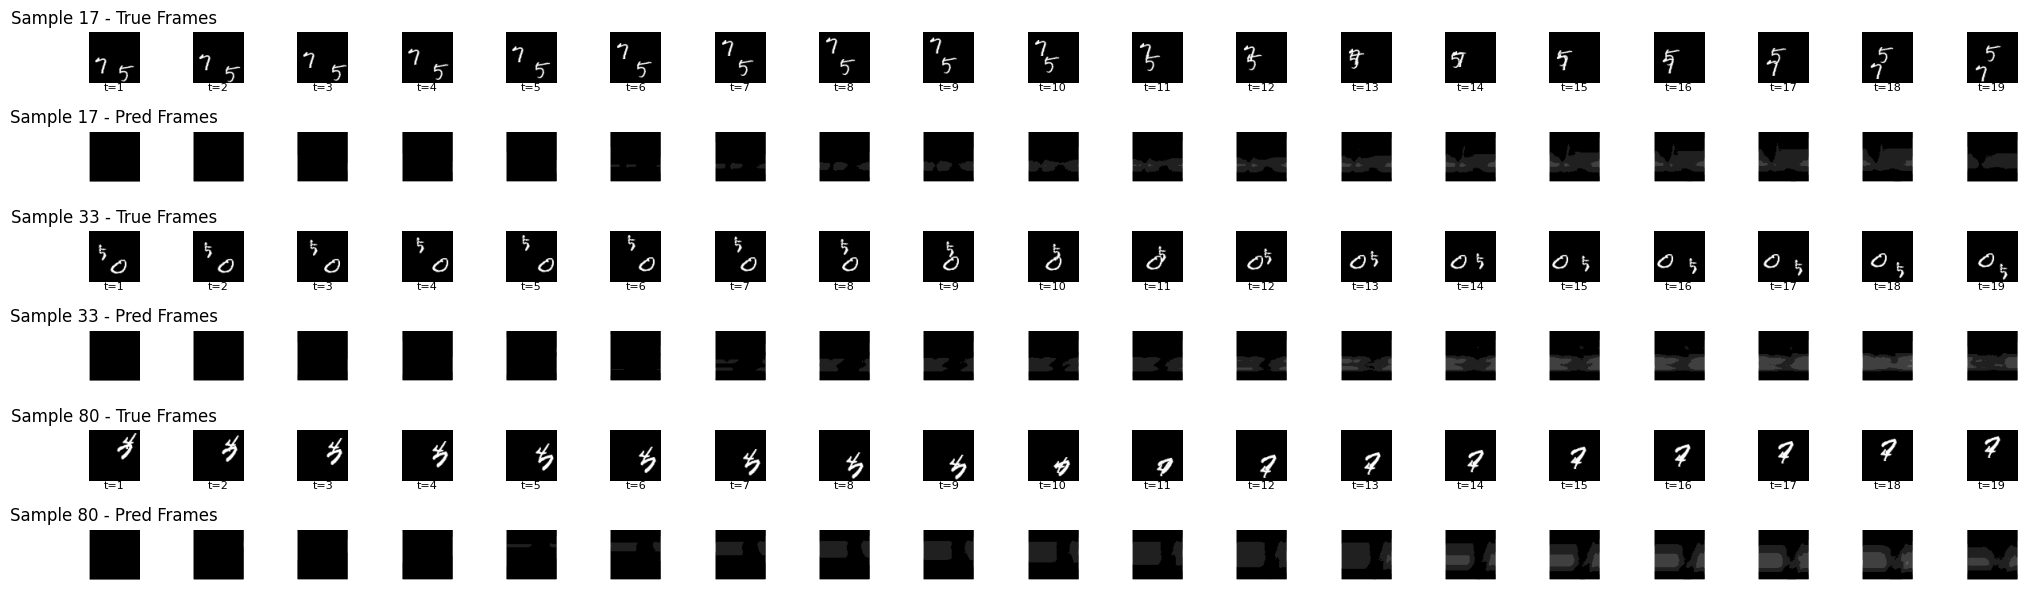

... finished with round: 1 ...
[176 579 666 123 687 738]
(32, 19, 64, 64, 1) (32, 19, 64, 64, 1)


  0%|          | 0/32 [00:00<?, ?it/s]

Generator Loss: 0.675271571 ; Instructor Loss: 1.38502431


  3%|▎         | 1/32 [00:00<00:30,  1.02it/s]

Generator Loss: 0.693971157 ; Instructor Loss: 1.38102186


  6%|▋         | 2/32 [00:01<00:27,  1.09it/s]

Generator Loss: 0.697198749 ; Instructor Loss: 1.3899436


  9%|▉         | 3/32 [00:02<00:26,  1.10it/s]

Generator Loss: 0.689602196 ; Instructor Loss: 1.38830745


 12%|█▎        | 4/32 [00:03<00:25,  1.11it/s]

Generator Loss: 0.690266 ; Instructor Loss: 1.383816


 16%|█▌        | 5/32 [00:04<00:24,  1.12it/s]

Generator Loss: 0.691364706 ; Instructor Loss: 1.39448619


 19%|█▉        | 6/32 [00:05<00:23,  1.12it/s]

Generator Loss: 0.674875915 ; Instructor Loss: 1.3864646


 22%|██▏       | 7/32 [00:06<00:22,  1.12it/s]

Generator Loss: 0.655953407 ; Instructor Loss: 1.38924527


 25%|██▌       | 8/32 [00:07<00:21,  1.13it/s]

Generator Loss: 0.668914914 ; Instructor Loss: 1.38526


 28%|██▊       | 9/32 [00:08<00:20,  1.13it/s]

Generator Loss: 0.675709605 ; Instructor Loss: 1.38479471


 31%|███▏      | 10/32 [00:08<00:19,  1.13it/s]

Generator Loss: 0.669358194 ; Instructor Loss: 1.38640118


 34%|███▍      | 11/32 [00:09<00:18,  1.13it/s]

Generator Loss: 0.688904107 ; Instructor Loss: 1.3897804


 38%|███▊      | 12/32 [00:10<00:17,  1.13it/s]

Generator Loss: 0.696325839 ; Instructor Loss: 1.3883816


 41%|████      | 13/32 [00:11<00:16,  1.13it/s]

Generator Loss: 0.700372458 ; Instructor Loss: 1.3833195


 44%|████▍     | 14/32 [00:12<00:15,  1.14it/s]

Generator Loss: 0.699115753 ; Instructor Loss: 1.39085031


 47%|████▋     | 15/32 [00:13<00:14,  1.14it/s]

Generator Loss: 0.694442391 ; Instructor Loss: 1.36664653


 50%|█████     | 16/32 [00:14<00:14,  1.14it/s]

Generator Loss: 0.715842068 ; Instructor Loss: 1.37869024


 53%|█████▎    | 17/32 [00:15<00:13,  1.14it/s]

Generator Loss: 0.661317647 ; Instructor Loss: 1.3873297


 56%|█████▋    | 18/32 [00:15<00:12,  1.14it/s]

Generator Loss: 0.674523115 ; Instructor Loss: 1.38679743


 59%|█████▉    | 19/32 [00:16<00:11,  1.14it/s]

Generator Loss: 0.70028007 ; Instructor Loss: 1.39315081


 62%|██████▎   | 20/32 [00:17<00:10,  1.14it/s]

Generator Loss: 0.675133944 ; Instructor Loss: 1.38718486


 66%|██████▌   | 21/32 [00:18<00:09,  1.14it/s]

Generator Loss: 0.692006588 ; Instructor Loss: 1.37783873


 69%|██████▉   | 22/32 [00:19<00:08,  1.14it/s]

Generator Loss: 0.72871 ; Instructor Loss: 1.39266336


 72%|███████▏  | 23/32 [00:20<00:07,  1.14it/s]

Generator Loss: 0.679445446 ; Instructor Loss: 1.38942754


 75%|███████▌  | 24/32 [00:21<00:06,  1.14it/s]

Generator Loss: 0.61488384 ; Instructor Loss: 1.40071726


 78%|███████▊  | 25/32 [00:22<00:06,  1.14it/s]

Generator Loss: 0.635084 ; Instructor Loss: 1.38116014


 81%|████████▏ | 26/32 [00:22<00:05,  1.14it/s]

Generator Loss: 0.643449962 ; Instructor Loss: 1.38670945


 84%|████████▍ | 27/32 [00:23<00:04,  1.14it/s]

Generator Loss: 0.662292242 ; Instructor Loss: 1.38390911


 88%|████████▊ | 28/32 [00:24<00:03,  1.14it/s]

Generator Loss: 0.661187768 ; Instructor Loss: 1.38399935


 91%|█████████ | 29/32 [00:25<00:02,  1.13it/s]

Generator Loss: 0.810447156 ; Instructor Loss: 1.392802


 94%|█████████▍| 30/32 [00:26<00:01,  1.13it/s]

Generator Loss: 0.822425842 ; Instructor Loss: 1.36313081


 97%|█████████▋| 31/32 [00:27<00:00,  1.13it/s]

Generator Loss: 0.813984573 ; Instructor Loss: 1.36196256


100%|██████████| 32/32 [00:28<00:00,  1.13it/s]


Time for epoch 1 is 28.29385781288147 sec
4/4 [==============================] - 5s 1s/step
Shape of true y_val: (100, 19, 64, 64, 1)
Shape of predicted y_val: (100, 19, 64, 64, 1)


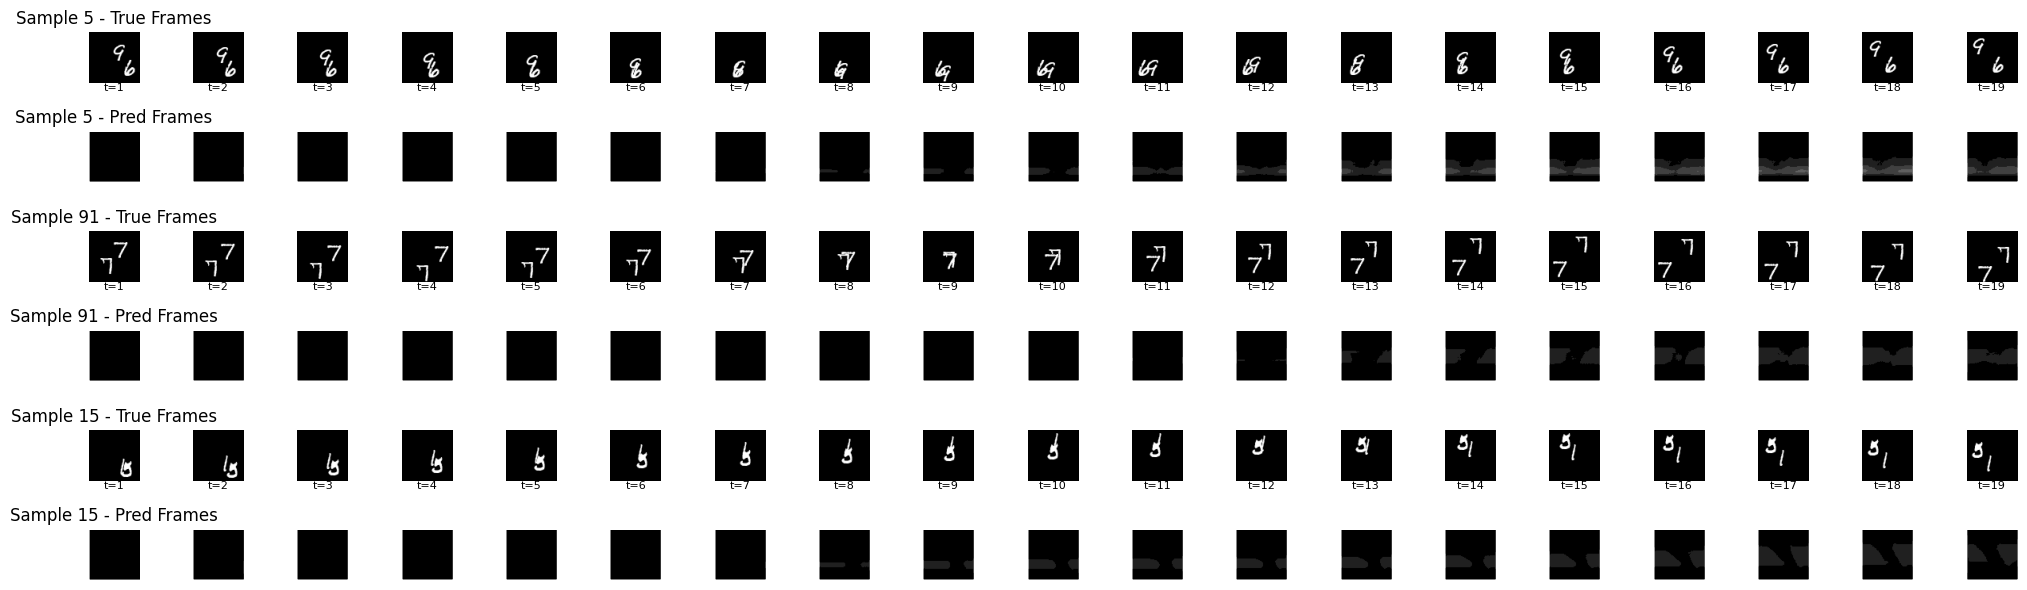

... finished with round: 2 ...
[299 423  92 273 409 687]
(32, 19, 64, 64, 1) (32, 19, 64, 64, 1)


  0%|          | 0/32 [00:00<?, ?it/s]

Generator Loss: 0.784309566 ; Instructor Loss: 1.4066813


  3%|▎         | 1/32 [00:00<00:30,  1.02it/s]

Generator Loss: 0.774822235 ; Instructor Loss: 1.40199506


  6%|▋         | 2/32 [00:01<00:27,  1.09it/s]

Generator Loss: 0.773708 ; Instructor Loss: 1.39693856


  9%|▉         | 3/32 [00:02<00:26,  1.11it/s]

Generator Loss: 0.780405819 ; Instructor Loss: 1.39741158


 12%|█▎        | 4/32 [00:03<00:25,  1.12it/s]

Generator Loss: 0.765879393 ; Instructor Loss: 1.39521658


 16%|█▌        | 5/32 [00:04<00:23,  1.13it/s]

Generator Loss: 0.755241334 ; Instructor Loss: 1.39216828


 19%|█▉        | 6/32 [00:05<00:22,  1.13it/s]

Generator Loss: 0.735301495 ; Instructor Loss: 1.3786037


 22%|██▏       | 7/32 [00:06<00:22,  1.13it/s]

Generator Loss: 0.720109284 ; Instructor Loss: 1.38539779


 25%|██▌       | 8/32 [00:07<00:21,  1.14it/s]

Generator Loss: 0.707254052 ; Instructor Loss: 1.38226473


 28%|██▊       | 9/32 [00:08<00:20,  1.14it/s]

Generator Loss: 0.675481796 ; Instructor Loss: 1.38894796


 31%|███▏      | 10/32 [00:08<00:19,  1.14it/s]

Generator Loss: 0.666058838 ; Instructor Loss: 1.38378978


 34%|███▍      | 11/32 [00:09<00:18,  1.14it/s]

Generator Loss: 0.652399302 ; Instructor Loss: 1.38688803


 38%|███▊      | 12/32 [00:10<00:17,  1.13it/s]

Generator Loss: 0.643442452 ; Instructor Loss: 1.38832378


 41%|████      | 13/32 [00:11<00:16,  1.13it/s]

Generator Loss: 0.638431847 ; Instructor Loss: 1.38677716


 44%|████▍     | 14/32 [00:12<00:15,  1.13it/s]

Generator Loss: 0.629429936 ; Instructor Loss: 1.39675379


 47%|████▋     | 15/32 [00:13<00:15,  1.13it/s]

Generator Loss: 0.637788534 ; Instructor Loss: 1.38823509


 50%|█████     | 16/32 [00:14<00:14,  1.13it/s]

Generator Loss: 0.644772828 ; Instructor Loss: 1.38643587


 53%|█████▎    | 17/32 [00:15<00:13,  1.13it/s]

Generator Loss: 0.642221808 ; Instructor Loss: 1.39181185


 56%|█████▋    | 18/32 [00:15<00:12,  1.13it/s]

Generator Loss: 0.658502877 ; Instructor Loss: 1.38466537


 59%|█████▉    | 19/32 [00:16<00:11,  1.13it/s]

Generator Loss: 0.654762089 ; Instructor Loss: 1.38714051


 62%|██████▎   | 20/32 [00:17<00:10,  1.12it/s]

Generator Loss: 0.653199792 ; Instructor Loss: 1.38247299


 66%|██████▌   | 21/32 [00:18<00:09,  1.12it/s]

Generator Loss: 0.644180179 ; Instructor Loss: 1.38695776


 69%|██████▉   | 22/32 [00:19<00:08,  1.12it/s]

Generator Loss: 0.660597146 ; Instructor Loss: 1.39014208


 72%|███████▏  | 23/32 [00:20<00:08,  1.12it/s]

Generator Loss: 0.667825639 ; Instructor Loss: 1.38461542


 75%|███████▌  | 24/32 [00:21<00:07,  1.12it/s]

Generator Loss: 0.68182528 ; Instructor Loss: 1.38718867


 78%|███████▊  | 25/32 [00:22<00:06,  1.12it/s]

Generator Loss: 0.695209146 ; Instructor Loss: 1.38642836


 81%|████████▏ | 26/32 [00:23<00:05,  1.12it/s]

Generator Loss: 0.696819 ; Instructor Loss: 1.3868196


 84%|████████▍ | 27/32 [00:24<00:04,  1.12it/s]

Generator Loss: 0.70818162 ; Instructor Loss: 1.38576496


 88%|████████▊ | 28/32 [00:24<00:03,  1.12it/s]

Generator Loss: 0.699834883 ; Instructor Loss: 1.38606644


 91%|█████████ | 29/32 [00:25<00:02,  1.12it/s]

Generator Loss: 0.700624764 ; Instructor Loss: 1.39003706


 94%|█████████▍| 30/32 [00:26<00:01,  1.12it/s]

Generator Loss: 0.709085107 ; Instructor Loss: 1.38728499


 97%|█████████▋| 31/32 [00:27<00:00,  1.11it/s]

Generator Loss: 0.712617695 ; Instructor Loss: 1.38612926


100%|██████████| 32/32 [00:28<00:00,  1.12it/s]


Time for epoch 1 is 28.49956703186035 sec
4/4 [==============================] - 5s 1s/step
Shape of true y_val: (100, 19, 64, 64, 1)
Shape of predicted y_val: (100, 19, 64, 64, 1)


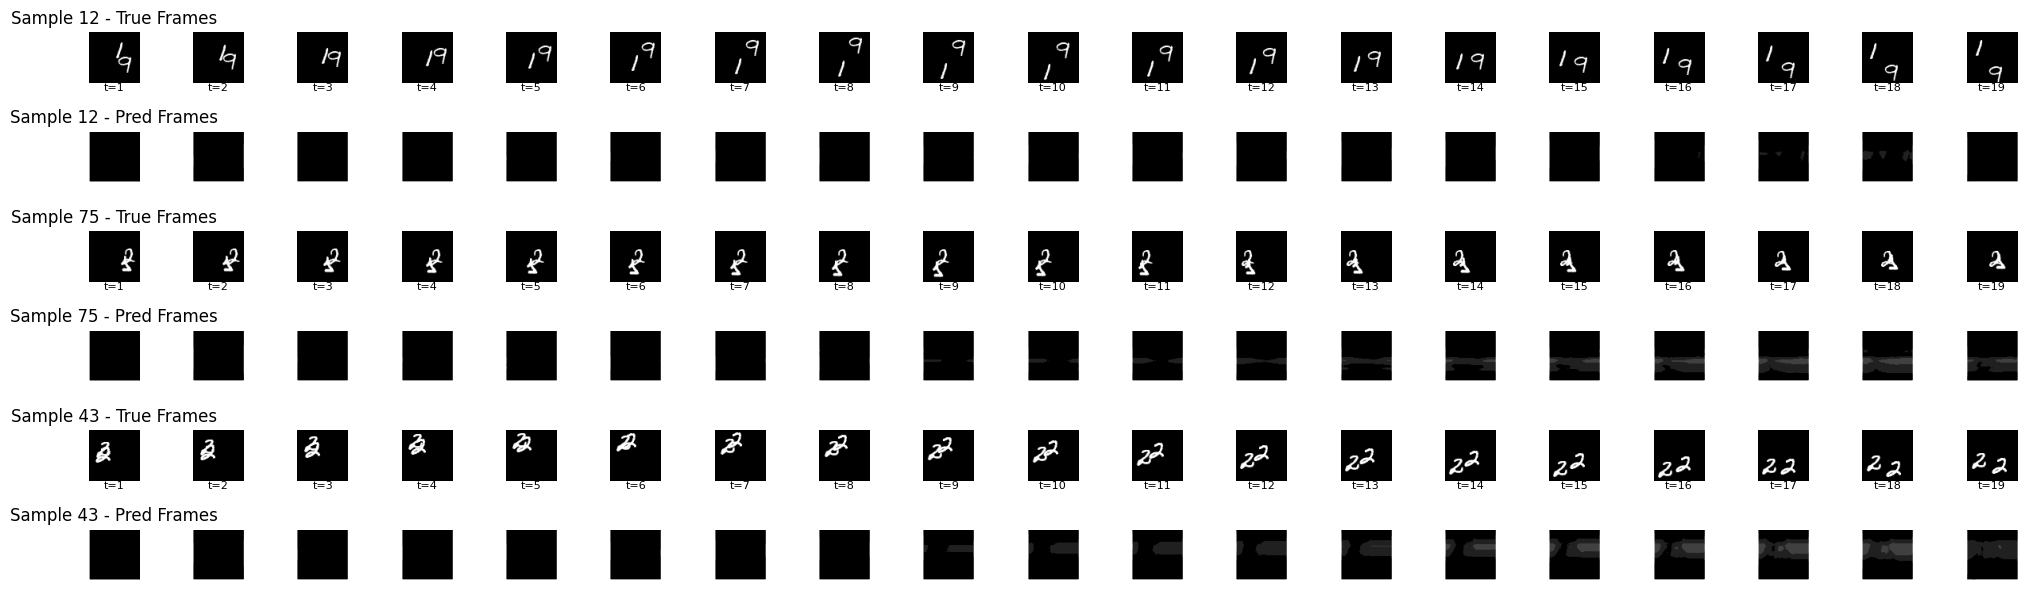

... finished with round: 3 ...
[876 276 266 771 372 357]
(32, 19, 64, 64, 1) (32, 19, 64, 64, 1)


  0%|          | 0/32 [00:00<?, ?it/s]

Generator Loss: 0.704966545 ; Instructor Loss: 1.38462162


  3%|▎         | 1/32 [00:00<00:30,  1.01it/s]

Generator Loss: 0.708557129 ; Instructor Loss: 1.38463473


  6%|▋         | 2/32 [00:01<00:27,  1.08it/s]

Generator Loss: 0.708041728 ; Instructor Loss: 1.38516092


  9%|▉         | 3/32 [00:02<00:26,  1.10it/s]

Generator Loss: 0.703518808 ; Instructor Loss: 1.38528466


 12%|█▎        | 4/32 [00:03<00:25,  1.11it/s]

Generator Loss: 0.696647108 ; Instructor Loss: 1.3849287


 16%|█▌        | 5/32 [00:04<00:24,  1.12it/s]

Generator Loss: 0.69473058 ; Instructor Loss: 1.3859241


 19%|█▉        | 6/32 [00:05<00:23,  1.12it/s]

Generator Loss: 0.698436439 ; Instructor Loss: 1.38615763


 22%|██▏       | 7/32 [00:06<00:22,  1.12it/s]

Generator Loss: 0.691621184 ; Instructor Loss: 1.38503766


 25%|██▌       | 8/32 [00:07<00:21,  1.12it/s]

Generator Loss: 0.680855334 ; Instructor Loss: 1.38783669


 28%|██▊       | 9/32 [00:08<00:20,  1.12it/s]

Generator Loss: 0.691156566 ; Instructor Loss: 1.38577461


 31%|███▏      | 10/32 [00:08<00:19,  1.13it/s]

Generator Loss: 0.672618091 ; Instructor Loss: 1.38550901


 34%|███▍      | 11/32 [00:09<00:18,  1.13it/s]

Generator Loss: 0.668631554 ; Instructor Loss: 1.38560617


 38%|███▊      | 12/32 [00:10<00:17,  1.13it/s]

Generator Loss: 0.689929903 ; Instructor Loss: 1.38580847


 41%|████      | 13/32 [00:11<00:16,  1.13it/s]

Generator Loss: 0.672013462 ; Instructor Loss: 1.38436723


 44%|████▍     | 14/32 [00:12<00:16,  1.12it/s]

Generator Loss: 0.692796 ; Instructor Loss: 1.38506126


 47%|████▋     | 15/32 [00:13<00:15,  1.12it/s]

Generator Loss: 0.678655624 ; Instructor Loss: 1.39076757


 50%|█████     | 16/32 [00:14<00:14,  1.12it/s]

Generator Loss: 0.68682313 ; Instructor Loss: 1.38414562


 53%|█████▎    | 17/32 [00:15<00:13,  1.12it/s]

Generator Loss: 0.686086595 ; Instructor Loss: 1.38893557


 56%|█████▋    | 18/32 [00:16<00:12,  1.13it/s]

Generator Loss: 0.685084581 ; Instructor Loss: 1.38640821


 59%|█████▉    | 19/32 [00:16<00:11,  1.13it/s]

Generator Loss: 0.69212693 ; Instructor Loss: 1.3862946


 62%|██████▎   | 20/32 [00:17<00:10,  1.13it/s]

Generator Loss: 0.704698801 ; Instructor Loss: 1.38467824


 66%|██████▌   | 21/32 [00:18<00:09,  1.13it/s]

Generator Loss: 0.695183 ; Instructor Loss: 1.38256955


 69%|██████▉   | 22/32 [00:19<00:08,  1.13it/s]

Generator Loss: 0.712003469 ; Instructor Loss: 1.39383793


 72%|███████▏  | 23/32 [00:20<00:07,  1.13it/s]

Generator Loss: 0.707766712 ; Instructor Loss: 1.38671398


 75%|███████▌  | 24/32 [00:21<00:07,  1.13it/s]

Generator Loss: 0.698753834 ; Instructor Loss: 1.38279867


 78%|███████▊  | 25/32 [00:22<00:06,  1.13it/s]

Generator Loss: 0.71250248 ; Instructor Loss: 1.38890195


 81%|████████▏ | 26/32 [00:23<00:05,  1.13it/s]

Generator Loss: 0.706769288 ; Instructor Loss: 1.38335323


 84%|████████▍ | 27/32 [00:24<00:04,  1.11it/s]

Generator Loss: 0.720634401 ; Instructor Loss: 1.38389778


 88%|████████▊ | 28/32 [00:24<00:03,  1.11it/s]

Generator Loss: 0.689115942 ; Instructor Loss: 1.38623869


 91%|█████████ | 29/32 [00:25<00:02,  1.12it/s]

Generator Loss: 0.682997346 ; Instructor Loss: 1.38790441


 94%|█████████▍| 30/32 [00:26<00:01,  1.12it/s]

Generator Loss: 0.685648203 ; Instructor Loss: 1.39146471


 97%|█████████▋| 31/32 [00:27<00:00,  1.13it/s]

Generator Loss: 0.680069208 ; Instructor Loss: 1.39064789


100%|██████████| 32/32 [00:28<00:00,  1.12it/s]


Time for epoch 1 is 28.51809859275818 sec
4/4 [==============================] - 5s 1s/step
Shape of true y_val: (100, 19, 64, 64, 1)
Shape of predicted y_val: (100, 19, 64, 64, 1)


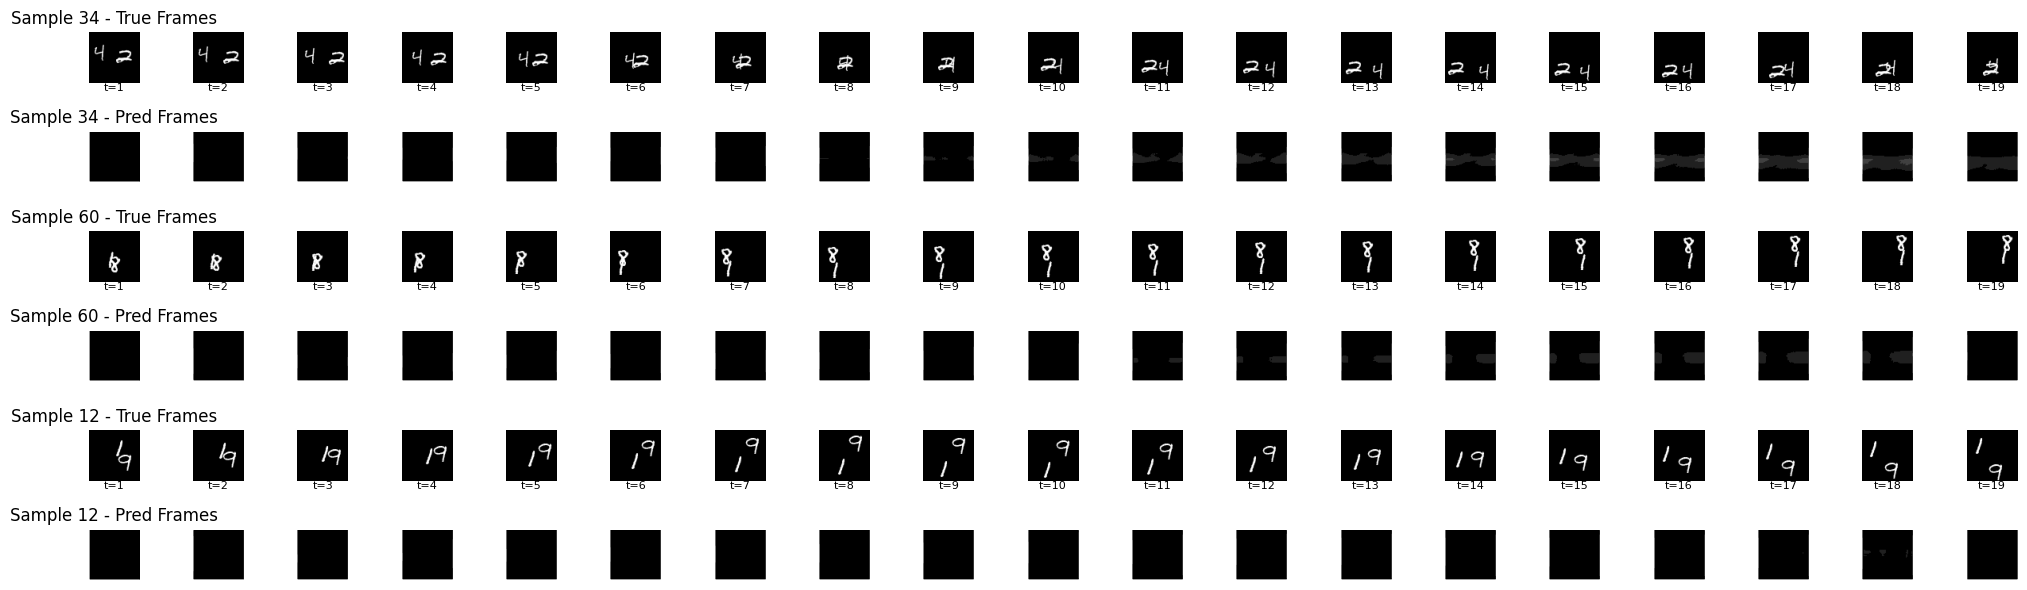

... finished with round: 4 ...
[846 720 237 197  45 182]
(32, 19, 64, 64, 1) (32, 19, 64, 64, 1)


  0%|          | 0/32 [00:00<?, ?it/s]

Generator Loss: 0.680507541 ; Instructor Loss: 1.38169885


  3%|▎         | 1/32 [00:00<00:29,  1.04it/s]

Generator Loss: 0.671460807 ; Instructor Loss: 1.38116455


  6%|▋         | 2/32 [00:01<00:27,  1.10it/s]

Generator Loss: 0.671543419 ; Instructor Loss: 1.38932586


  9%|▉         | 3/32 [00:02<00:26,  1.11it/s]

Generator Loss: 0.65994072 ; Instructor Loss: 1.38966036


 12%|█▎        | 4/32 [00:03<00:24,  1.12it/s]

Generator Loss: 0.671834648 ; Instructor Loss: 1.38449


 16%|█▌        | 5/32 [00:04<00:23,  1.13it/s]

Generator Loss: 0.678349674 ; Instructor Loss: 1.39111


 19%|█▉        | 6/32 [00:05<00:23,  1.13it/s]

Generator Loss: 0.676607668 ; Instructor Loss: 1.38647175


 22%|██▏       | 7/32 [00:06<00:22,  1.13it/s]

Generator Loss: 0.68668139 ; Instructor Loss: 1.38252366


 25%|██▌       | 8/32 [00:07<00:21,  1.13it/s]

Generator Loss: 0.68877846 ; Instructor Loss: 1.3863889


 28%|██▊       | 9/32 [00:08<00:20,  1.13it/s]

Generator Loss: 0.698037922 ; Instructor Loss: 1.38815165


 31%|███▏      | 10/32 [00:08<00:19,  1.13it/s]

Generator Loss: 0.708865225 ; Instructor Loss: 1.3857975


 34%|███▍      | 11/32 [00:09<00:18,  1.13it/s]

Generator Loss: 0.703340828 ; Instructor Loss: 1.38579559


 38%|███▊      | 12/32 [00:10<00:17,  1.13it/s]

Generator Loss: 0.702916324 ; Instructor Loss: 1.38347244


 41%|████      | 13/32 [00:11<00:16,  1.12it/s]

Generator Loss: 0.712217033 ; Instructor Loss: 1.38732588


 44%|████▍     | 14/32 [00:12<00:15,  1.13it/s]

Generator Loss: 0.71148026 ; Instructor Loss: 1.37885475


 47%|████▋     | 15/32 [00:13<00:15,  1.12it/s]

Generator Loss: 0.697192848 ; Instructor Loss: 1.38848889


 50%|█████     | 16/32 [00:14<00:14,  1.12it/s]

Generator Loss: 0.687454343 ; Instructor Loss: 1.38839245


 53%|█████▎    | 17/32 [00:15<00:13,  1.12it/s]

Generator Loss: 0.671541 ; Instructor Loss: 1.38513672


 56%|█████▋    | 18/32 [00:16<00:12,  1.12it/s]

Generator Loss: 0.674156606 ; Instructor Loss: 1.38252151


 59%|█████▉    | 19/32 [00:16<00:11,  1.12it/s]

Generator Loss: 0.66883707 ; Instructor Loss: 1.37291074


 62%|██████▎   | 20/32 [00:17<00:10,  1.12it/s]

Generator Loss: 0.670098364 ; Instructor Loss: 1.3765744


 66%|██████▌   | 21/32 [00:18<00:09,  1.12it/s]

Generator Loss: 0.650933862 ; Instructor Loss: 1.38007045


 69%|██████▉   | 22/32 [00:19<00:08,  1.12it/s]

Generator Loss: 0.694280088 ; Instructor Loss: 1.40106726


 72%|███████▏  | 23/32 [00:20<00:08,  1.12it/s]

Generator Loss: 0.712719798 ; Instructor Loss: 1.3867867


 75%|███████▌  | 24/32 [00:21<00:07,  1.12it/s]

Generator Loss: 0.700246811 ; Instructor Loss: 1.41560936


 78%|███████▊  | 25/32 [00:22<00:06,  1.12it/s]

Generator Loss: 0.719449759 ; Instructor Loss: 1.39446723


 81%|████████▏ | 26/32 [00:23<00:05,  1.12it/s]

Generator Loss: 0.706671298 ; Instructor Loss: 1.41325545


 84%|████████▍ | 27/32 [00:24<00:04,  1.12it/s]

Generator Loss: 0.719571471 ; Instructor Loss: 1.39025187


 88%|████████▊ | 28/32 [00:24<00:03,  1.12it/s]

Generator Loss: 0.709528446 ; Instructor Loss: 1.38829339


 91%|█████████ | 29/32 [00:25<00:02,  1.12it/s]

Generator Loss: 0.706959724 ; Instructor Loss: 1.39554882


 94%|█████████▍| 30/32 [00:26<00:01,  1.12it/s]

Generator Loss: 0.667157769 ; Instructor Loss: 1.36975121


 97%|█████████▋| 31/32 [00:27<00:00,  1.12it/s]

Generator Loss: 0.644646406 ; Instructor Loss: 1.39208031


100%|██████████| 32/32 [00:28<00:00,  1.12it/s]


Time for epoch 1 is 28.51350975036621 sec
4/4 [==============================] - 5s 1s/step
Shape of true y_val: (100, 19, 64, 64, 1)
Shape of predicted y_val: (100, 19, 64, 64, 1)


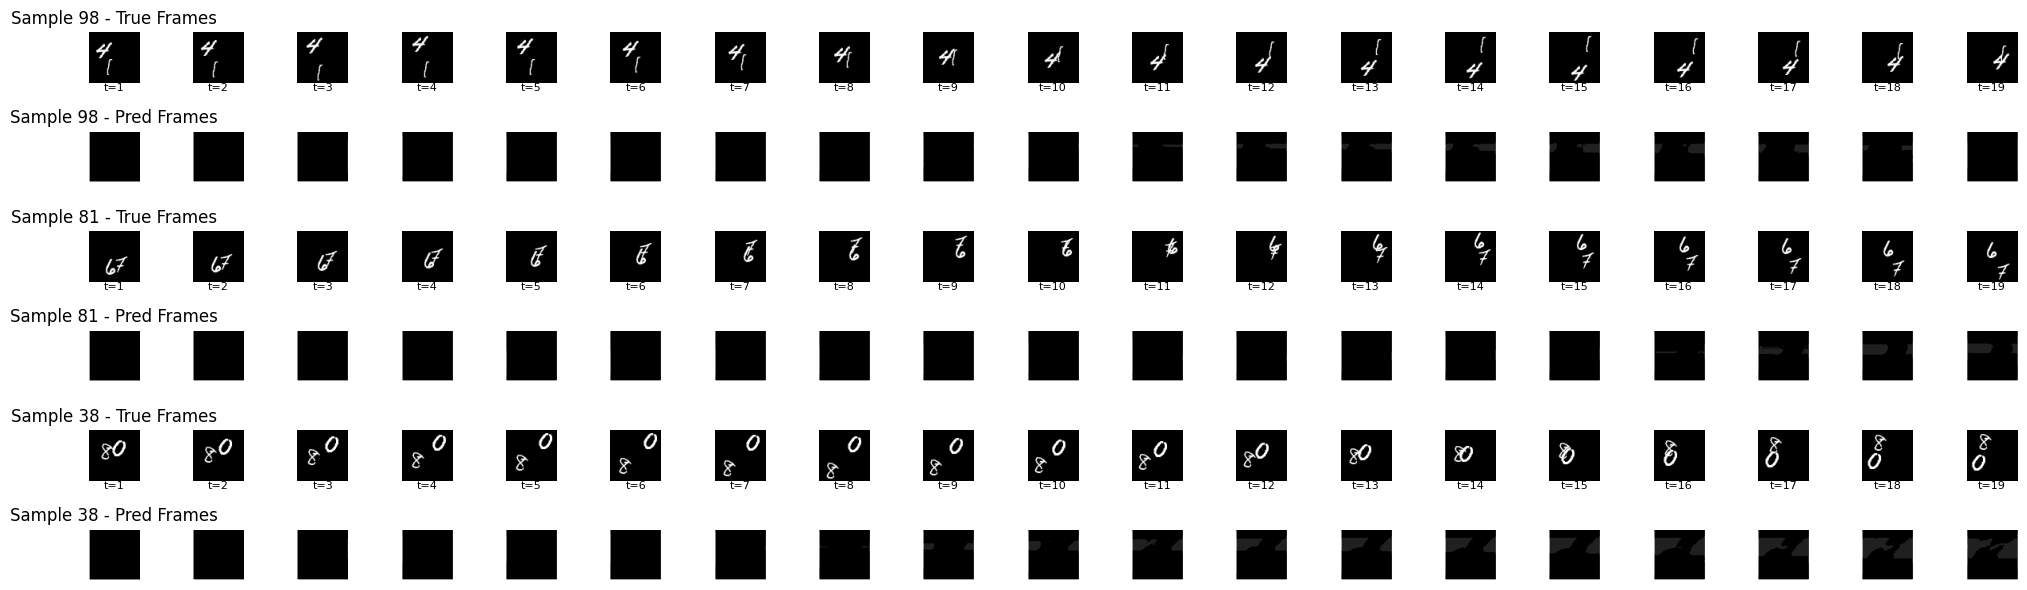

... finished with round: 5 ...
[505 456   8 146 155  99]
(32, 19, 64, 64, 1) (32, 19, 64, 64, 1)


  0%|          | 0/32 [00:00<?, ?it/s]

Generator Loss: 0.669890642 ; Instructor Loss: 1.37590814


  3%|▎         | 1/32 [00:00<00:30,  1.02it/s]

Generator Loss: 0.685780048 ; Instructor Loss: 1.39679229


  6%|▋         | 2/32 [00:01<00:27,  1.08it/s]

Generator Loss: 0.740971684 ; Instructor Loss: 1.39100623


  9%|▉         | 3/32 [00:02<00:26,  1.10it/s]

Generator Loss: 0.726399899 ; Instructor Loss: 1.38780236


 12%|█▎        | 4/32 [00:03<00:25,  1.11it/s]

Generator Loss: 0.776583254 ; Instructor Loss: 1.38758111


 16%|█▌        | 5/32 [00:04<00:24,  1.12it/s]

Generator Loss: 0.718904197 ; Instructor Loss: 1.39021611


 19%|█▉        | 6/32 [00:05<00:23,  1.12it/s]

Generator Loss: 0.683784723 ; Instructor Loss: 1.38971221


 22%|██▏       | 7/32 [00:06<00:22,  1.12it/s]

Generator Loss: 0.663075924 ; Instructor Loss: 1.37352395


 25%|██▌       | 8/32 [00:07<00:21,  1.12it/s]

Generator Loss: 0.642662 ; Instructor Loss: 1.37290478


 28%|██▊       | 9/32 [00:08<00:20,  1.12it/s]

Generator Loss: 0.653815627 ; Instructor Loss: 1.38441598


 31%|███▏      | 10/32 [00:08<00:19,  1.13it/s]

Generator Loss: 0.691920698 ; Instructor Loss: 1.3796519


 34%|███▍      | 11/32 [00:09<00:18,  1.13it/s]

Generator Loss: 0.640777647 ; Instructor Loss: 1.38434935


 38%|███▊      | 12/32 [00:10<00:17,  1.13it/s]

Generator Loss: 0.620385766 ; Instructor Loss: 1.41496515


 41%|████      | 13/32 [00:11<00:16,  1.13it/s]

Generator Loss: 0.647637546 ; Instructor Loss: 1.40313387


 44%|████▍     | 14/32 [00:12<00:16,  1.12it/s]

Generator Loss: 0.666766882 ; Instructor Loss: 1.41667497


 47%|████▋     | 15/32 [00:13<00:15,  1.13it/s]

Generator Loss: 0.634732544 ; Instructor Loss: 1.38566709


 50%|█████     | 16/32 [00:14<00:14,  1.12it/s]

Generator Loss: 0.64896816 ; Instructor Loss: 1.40020061


 53%|█████▎    | 17/32 [00:15<00:13,  1.12it/s]

Generator Loss: 0.690671802 ; Instructor Loss: 1.3804487


 56%|█████▋    | 18/32 [00:16<00:12,  1.13it/s]

Generator Loss: 0.720325768 ; Instructor Loss: 1.40232825


 59%|█████▉    | 19/32 [00:16<00:11,  1.13it/s]

Generator Loss: 0.769183397 ; Instructor Loss: 1.38594246


 62%|██████▎   | 20/32 [00:17<00:10,  1.13it/s]

Generator Loss: 0.758496 ; Instructor Loss: 1.39380741


 66%|██████▌   | 21/32 [00:18<00:09,  1.13it/s]

Generator Loss: 0.775445938 ; Instructor Loss: 1.38465643


 69%|██████▉   | 22/32 [00:19<00:08,  1.13it/s]

Generator Loss: 0.752365232 ; Instructor Loss: 1.3837713


 72%|███████▏  | 23/32 [00:20<00:07,  1.13it/s]

Generator Loss: 0.727721572 ; Instructor Loss: 1.38949919


 75%|███████▌  | 24/32 [00:21<00:07,  1.13it/s]

Generator Loss: 0.747548044 ; Instructor Loss: 1.37316322


 78%|███████▊  | 25/32 [00:22<00:06,  1.13it/s]

Generator Loss: 0.708863437 ; Instructor Loss: 1.40164542


 81%|████████▏ | 26/32 [00:23<00:05,  1.13it/s]

Generator Loss: 0.690149784 ; Instructor Loss: 1.38212967


 84%|████████▍ | 27/32 [00:24<00:04,  1.13it/s]

Generator Loss: 0.65190661 ; Instructor Loss: 1.38494778


 88%|████████▊ | 28/32 [00:24<00:03,  1.13it/s]

Generator Loss: 0.671087325 ; Instructor Loss: 1.38623345


 91%|█████████ | 29/32 [00:25<00:02,  1.13it/s]

Generator Loss: 0.63324672 ; Instructor Loss: 1.40130281


 94%|█████████▍| 30/32 [00:26<00:01,  1.13it/s]

Generator Loss: 0.630345106 ; Instructor Loss: 1.39930797


 97%|█████████▋| 31/32 [00:27<00:00,  1.13it/s]

Generator Loss: 0.635387 ; Instructor Loss: 1.39685726


100%|██████████| 32/32 [00:28<00:00,  1.12it/s]


Time for epoch 1 is 28.497240781784058 sec
4/4 [==============================] - 5s 1s/step
Shape of true y_val: (100, 19, 64, 64, 1)
Shape of predicted y_val: (100, 19, 64, 64, 1)


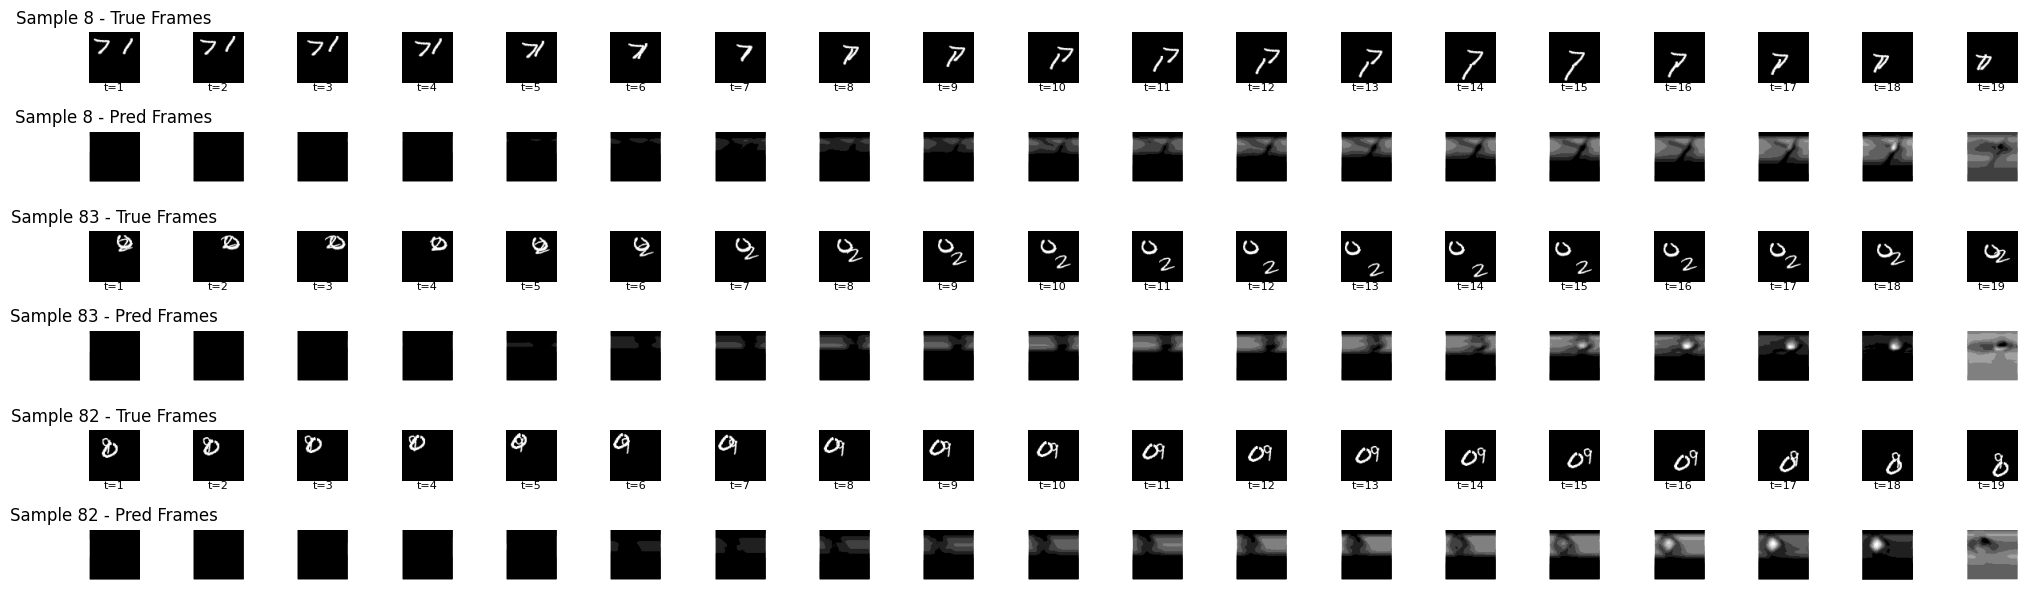

... finished with round: 6 ...
CPU times: user 4min 7s, sys: 55.8 s, total: 5min 3s
Wall time: 5min 20s


In [23]:
%%time

for j in range(7):

    # Assuming x_train and y_train are already defined and loaded
    num_samples = 32
    indices = np.random.choice(x_train.shape[0], num_samples, replace=False)
    print(indices[0:6])
    x_train_sub = x_train[indices]
    y_train_sub = y_train[indices]
    print(x_train_sub.shape, y_train_sub.shape)

    # Example usage:
    if tf.test.gpu_device_name() != '':
        with tf.device('/device:GPU:0'):
            train(x_train_sub, y_train_sub, epochs=1, batch_size=1)
    else:
        train(x_train_sub, y_train_sub, epochs=1, batch_size=1)


    # prediction on validation set
    y_val_pred = gen_past.predict(x_val)

    print("Shape of true y_val:", y_val.shape)
    print("Shape of predicted y_val:", y_val_pred.shape)


    # Set up the figure with specified dimensions
    plt.figure(figsize=(20, 6))

    # Randomly select 5 samples
    num_samples = 3
    indices = np.random.choice(y_val.shape[0], num_samples, replace=False)

    # Total number of plots per sample (19 predictions + 19 actuals)
    num_plots_per_sample = 19 * 2  # 19 predicted and 19 actual

    # Iterate over each of the randomly selected samples
    for idx, sample_index in enumerate(indices):
        # First row for y_val (true values)
        for i in range(19):
            ax = plt.subplot(num_samples * 2, 19, 2 * idx * 19 + i + 1)  # Calculate position index
            plt.imshow(y_val[sample_index, i, :, :, 0], cmap='gray')
            plt.axis('off')
            if i == 0:
                plt.title(f'Sample {sample_index+1} - True Frames')
            plt.text(0.5, -0.1, f't={i+1}', ha='center', va='center', transform=ax.transAxes, fontsize=8)  # Adding time label

        # Second row for y_val_pred (predicted values)
        for i in range(19):
            plt.subplot(num_samples * 2, 19, (2 * idx + 1) * 19 + i + 1)  # Calculate position index
            image = y_val_pred[sample_index, i, :, :, 0]
            result_image = rescale_and_discretize(image)
            plt.imshow(result_image, cmap='gray')
            plt.axis('off')
            if i == 0:
                plt.title(f'Sample {sample_index+1} - Pred Frames')

    plt.tight_layout()
    plt.show()

    print(f"... finished with round: {j} ...")

### Tuning

## Create `.gif`

In [ ]:
# Create a directory for the GIFs
gif_dir = "predicted_gifs_instruct_vapaad_stop_grad"
os.makedirs(gif_dir, exist_ok=True)

# Select a few random examples from the dataset.
examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

# Iterate over the examples and predict the frames.
predicted_videos = []
for index, example in enumerate(examples):
    # Pick the first/last ten frames from the example.
    frames = example[:10, ...]
    original_frames = example[10:, ...]
    new_predictions = np.zeros(shape=(10, *frames[0].shape))

    # Predict a new set of 10 frames.
    for i in range(10):
        # Extract the generator's prediction and post-process it.
        frames = example[: 10 + i + 1, ...]
        new_prediction = gen_past.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Extend the set of prediction frames.
        new_predictions[i] = predicted_frame

    # Create and save GIFs for each of the ground truth/prediction images.
    for frame_set_idx, frame_set in enumerate([original_frames, new_predictions]):
        # Construct a GIF from the selected video frames.
        current_frames = np.squeeze(frame_set)
        current_frames = current_frames[..., np.newaxis] * np.ones(3)
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        # Define the GIF filepath
        gif_filename = os.path.join(gif_dir, f"example_{index}_{'original' if frame_set_idx == 0 else 'predicted'}.gif")

        # Save the GIF
        imageio.mimsave(gif_filename, current_frames, "GIF", duration=0.2)

        # To display the videos inline, you can open and read the saved GIF
        with open(gif_filename, 'rb') as gif_file:
            predicted_videos.append(gif_file.read())

# Display the videos inline in the notebook.
print("Truth\tPrediction")
for i in range(0, len(predicted_videos), 2):
    box = HBox(
        [
            widgets.Image(value=predicted_videos[i], format='gif'),
            widgets.Image(value=predicted_videos[i + 1], format='gif'),
        ]
    )
    display(box)


1/1 [==============================] - 1s 846ms/step
Truth	Prediction
